In [1]:
import rospy
from sensor_msgs.msg import PointCloud2, Image, PointField
import sensor_msgs.point_cloud2 as pc2
from std_msgs.msg import Header
from velodyne_msgs.msg import VelodyneScan
import numpy as np
import cupy as cp
import cupyx as cpx
import matplotlib.pyplot as plt
from cv_bridge import CvBridge
import time
import cv2
import open3d as o3d
import math


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
ZED_TOPIC = '/islam/zed_depth'
VLP_TOPIC = "/velodyne_points"
PG_TOPIC = "/islam/pg_depth"

In [3]:
ZED_V = 360
ZED_H = 640
ZED_H_ANGLE = 90
ZED_V_ANGLE = 60

LiDAR_V = 16
LiDAR_ANGLE = 30.2  # 0.2 degree precaution

In [4]:
def sph_to_cart_pts(pts):
    pts[:,1] = cp.radians(pts[:,1])
    pts[:,2] = cp.radians(pts[:,2])

    # Convert spherical coordinates to Cartesian coordinates
    x = pts[:, 0] * cp.cos(pts[:, 1]) * cp.cos(pts[:, 2])
    y = pts[:, 0] * cp.cos(pts[:, 1]) * cp.sin(pts[:, 2])
    z = pts[:, 0] * cp.sin(pts[:, 1])
    
    return cp.asarray([x, y, z]).T

def cart_to_sph_pts(pts):
    # Convert to CuPy array
    pts = cp.asarray(pts)

    # Convert to spherical coordinates
    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    r = cp.sqrt(x**2 + y**2 + z**2)
    theta = cp.arctan(z / cp.sqrt(x**2 + y**2))
    phi = cp.arctan(y / x)

    return cp.column_stack((r, cp.degrees(theta), cp.degrees(phi)))
    # return appendSpherical_np(pts)[:,3:6]

def msg2pts(msg):
    return cp.array(list(pc2.read_points(msg, field_names=("x", "y", "z"))))

In [5]:
def depth_to_sph_pts(depth):
    # Make sure input depth array is a CuPy array
    depth = cp.array(depth)
    
    # get the shape of the input array
    m, n = depth.shape
    azimuth_const = ZED_H_ANGLE/n
    polar_const = ZED_V_ANGLE/m

    # Create a grid of row and col indices
    row_indices, col_indices = cp.meshgrid(cp.arange(m), cp.arange(n), indexing='ij')

    # Calculate polar and azimuth angles
    polar_angles = row_indices * polar_const
    azimuth_angles = col_indices * azimuth_const

    # Stack the depth, polar_angles, and azimuth_angles along the last dimension
    pts = cp.stack((depth, polar_angles, azimuth_angles), axis=-1)

    # Reshape the pts array to the desired output shape (m * n, 3)
    pts = pts.reshape(m * n, 3)

    return pts

In [6]:
def lpf(img, ncutoff):
    # Apply 2D FFT to the image
    f = cp.fft.fft2(img)

    # Shift the zero frequency component to the center of the spectrum
    fshift = cp.fft.fftshift(f)

    # Create a circular mask of the same size as the spectrum
    rows, cols = img.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cutoff = int(min(crow, ccol)*ncutoff)
    cv2.circle(mask, (ccol, crow), cutoff, 1, -1)
    # cv2.ellipse(mask, (ccol, crow), (1, 2) * cutoff, 0, 0, 360,  1, -1)

    mask = cp.asarray(mask)

    # Apply the mask to the shifted spectrum
    fshift_filtered = fshift * mask

    # Shift the zero frequency component back to the corner of the spectrum
    f_filtered = cp.fft.ifftshift(fshift_filtered)

    # Apply the inverse 2D FFT to the filtered spectrum
    img_filtered = cp.fft.ifft2(f_filtered)
    img_filtered = cp.real(img_filtered)

    return img_filtered


def pg(zed_depth, vlp_depth, ncutoff, threshold=100):
    ncutoff = ncutoff / 10
    
    mask = vlp_depth > 0
    filtered = zed_depth
    filtered[mask] = vlp_depth[mask]
    
    while threshold > 0:
        filtered = lpf(filtered, ncutoff)
        filtered[mask] = vlp_depth[mask]

        threshold -= 1

    return filtered

In [7]:
def remap(old_value, old_min, old_max, new_min, new_max):
    # Function to map a value from one range to another
    old_range = old_max - old_min
    new_range = new_max - new_min
    new_value = (((old_value - old_min) * new_range) / old_range) + new_min
    return new_value

In [8]:
rospy.init_node('sf', anonymous=True)

In [11]:
pg_depth_p = rospy.Publisher(PG_TOPIC, Image, queue_size=50)
bridge = CvBridge()

zed_img = rospy.wait_for_message(ZED_TOPIC, Image)
ZED_V, ZED_H = cp.array(bridge.imgmsg_to_cv2(zed_img, "32FC1")).shape

while True:
    zed_img = rospy.wait_for_message(ZED_TOPIC, Image)
    vlp_pc = rospy.wait_for_message(VLP_TOPIC, PointCloud2)
    if zed_img and vlp_pc:
        s = time.time()
        # VLP Preproc
        vlp_pts = msg2pts(vlp_pc)
        vlp_sph_pts_raw = cart_to_sph_pts(vlp_pts[vlp_pts[:,0] > 0])
        mask = (vlp_sph_pts_raw[:, 2] < ZED_H_ANGLE/2) & (vlp_sph_pts_raw[:, 2] > -ZED_H_ANGLE/2)
        vlp_sph_pts = vlp_sph_pts_raw[mask]
        
        r, theta, phi = vlp_sph_pts.T
        theta = remap(theta, -LiDAR_ANGLE/2, LiDAR_ANGLE/2, 3*ZED_V//4, ZED_V//4).astype(cp.int32)
        phi = remap(phi, ZED_V_ANGLE/2, -ZED_V_ANGLE/2, 0, ZED_H).astype(cp.int32)

        vlp_depth = cp.zeros((ZED_V, ZED_H), dtype=cp.float32)

        cpx.scatter_add(vlp_depth, (theta, phi), r)
                
        # ZED Preproc
        zed_depth = cp.array(bridge.imgmsg_to_cv2(zed_img, "32FC1"))
        zed_depth[cp.isnan(zed_depth)] = cp.mean(vlp_sph_pts[:,0])
        zed_depth[zed_depth > 20] = cp.mean(vlp_sph_pts[:,0])
        
        # Sensor Fusion
        pg_depth = pg(zed_depth.copy(), vlp_depth.copy(), ncutoff=3, threshold=28)
        
        # Publish Image
        pg_depth_p.publish(bridge.cv2_to_imgmsg(pg_depth.get()))

KeyboardInterrupt: 

In [ ]:
rospy.signal_shutdown(reason='hebele')

In [ ]:
zed_img = rospy.wait_for_message('/zed/depth', Image)

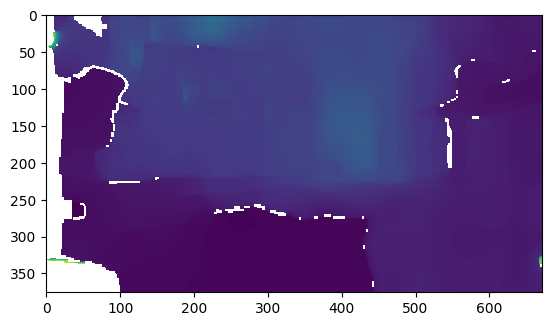

In [ ]:
msg = CvBridge()
plt.imshow(msg.imgmsg_to_cv2(zed_img))